# GloFAS - Attributes from static maps and model parameters
***

**_Autor:_** Chus Casado Rodríguez<br>
**_Fecha:_** 06-05-2025<br>

**Introduction:**<br>
This notebook creates the static attributes related to GloFAS static maps and model parameters.

**Ideas:**<br>
* [ ] Reservoir attributes using GRanD or GDW, instead of GloFAS. Find the reservoirs in those datasets within the catchment, count them, and sum the total storage.
* [ ] Lake attributes from HydroLakes, instead of GloFAS.

In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
# from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
from tqdm.auto import tqdm
from datetime import datetime
# from shapely.geometry import Point
# import yaml

from lisfloodreservoirs.utils import DatasetConfig
from lisfloodreservoirs.utils.plots import plot_attributes
from lisfloodreservoirs.catchstats import catchment_statistics

## Configuration

In [2]:
cfg = DatasetConfig('config_dataset.yml')

# directory where `cutmaps` results are saved
PATH_CUTMAPS = cfg.PATH_RESOPS / 'ancillary' / 'cutmaps'
# file used as input in `cutmaps`
OUTLETS = PATH_CUTMAPS / 'points_123.txt'
# name of the mask file
MASK_FILE = 'my_mask.nc'

print(f'Attribute tables will be saved in {cfg.PATH_ATTRS}')

Attribute tables will be saved in Z:\nahaUsers\casadje\datasets\reservoirs\ResOpsUS\v2.1\attributes


## Base information

### Catchments

In [3]:
# load TXT used as input for `cutmaps`
catchments = pd.read_csv(OUTLETS, sep='\t', header=None)#.squeeze()
catchments.columns = ['lon_orig', 'lat_orig', 'ID']
catchments.set_index('ID', drop=True, inplace=True)
catchments[['LON', 'LAT', 'CATCH_SKM']] = np.nan

###  Masks

The coordinates of the _my_mask.nc_ maps and those of the GloFAS static maps do not match at the nth decimal, so I have to recreate the maps from the _upArea.nc_ static map.

In [4]:
# load the upstream area map
upArea = xr.open_mfdataset(f'{cfg.PATH_LISFLOOD}/static_maps/upArea*.nc')['Band1'].compute()

# load the pixel area map
pixarea = xr.open_mfdataset(f'{cfg.PATH_LISFLOOD}/static_maps/pixarea*.nc')['Band1'].compute()

# recreate masks and find outlet and catchment area
masks = {}
directories = [entry for entry in PATH_CUTMAPS.iterdir() if entry.is_dir()]
for directory in tqdm(directories, desc='loading masks'):
    try:
        # ID
        ID = int(directory.stem)
        if ID not in catchments.index:
            print(f'{ID} not in the original list')
            continue

        # load original mask
        # mask = xr.open_dataset(directory / MASK_FILE)['Band1']
        mask = xr.open_dataarray(directory / MASK_FILE)
        mask = mask.rename({'x': 'lon', 'y': 'lat'})
        # mask.name = str(ID)

        # cut upArea map to the mask   
        upArea_masked = upArea.sel(lon=mask.lon, lat=mask.lat, method='nearest', tolerance=1e-3)
        mask['lon'] = upArea_masked.lon
        mask['lat'] = upArea_masked.lat
        upArea_masked = upArea_masked.where(mask == 1)        

        # find outlet and catchment area
        outlet = upArea_masked.isel(upArea_masked.argmax(dim=('lat', 'lon')))
        catchments.loc[ID, ['LAT', 'LON', 'CATCH_SKM']] = outlet.lat.item(), outlet.lon.item(), outlet.item()

        # create and save a mask out of the upArea map
        mask = xr.where(upArea_masked.notnull(), 1, upArea_masked)
        mask.name = str(ID)
        masks[ID] = mask

    except Exception as e: 
        print(directory, e)
        continue
        
# series of catchment area in km²
catchments.CATCH_SKM /= 1e6

# create point geodataframe
catchments = gpd.GeoDataFrame(
    catchments, 
    geometry=gpd.points_from_xy(catchments.LON, catchments.LAT))

loading masks:   0%|          | 0/123 [00:00<?, ?it/s]

In [5]:
# extent
lon_min, lon_max, lat_min, lat_max = catchments.LON.min(), catchments.LON.max(), catchments.LAT.min(), catchments.LAT.max()
for ID, mask in masks.items():
    lon_min = (np.min([lon_min, mask.lon.min()]))
    lon_max = np.max([lon_max, mask.lon.max()])
    lat_min = np.min([lat_min, mask.lat.min()])
    lat_max = np.max([lat_max, mask.lat.max()])
r = 5
lon_min = float(np.floor(lon_min / r) * r)
lon_max = float(np.ceil(lon_max / r) * r)
lat_min = float(np.floor(lat_min / r) * r)
lat_max = float(np.ceil(lat_max / r) * r)
# used in plots
extent = [lon_min, lon_max, lat_min, lat_max]
# used in cutting maps
extent_dct = {
    'lon': slice(lon_min, lon_max),
    'lat': slice(lat_max, lat_min)
    }

## LISFLOOD static maps

In this section I will compute catchment statistics of the LISFLOOD static maps that will be in the end exported as _glofas_static_maps.csv_. As ancillary maps, I have loaded first the pixel area and upstream area maps, that will be needed in the subsequent calculations.

In [99]:
# list where attributes will be appended
attributes = []

### Geomorphology

processing catchments:   0%|          | 0/123 [00:00<?, ?it/s]

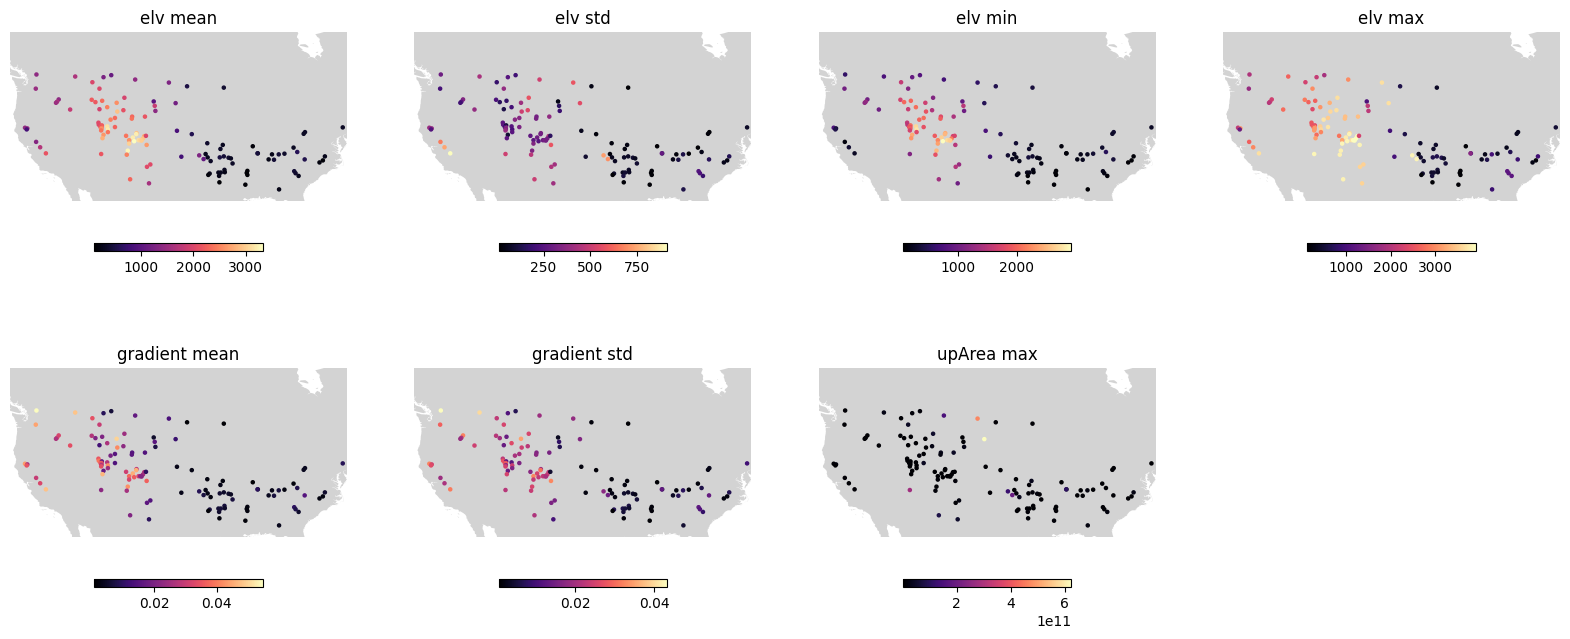

In [100]:
func = {'elv': ['mean', 'std', 'min', 'max'],
        'gradient': ['mean', 'std'],
        'upArea': ['max'],
        # 'pixarea': ['sum']
       }

# load maps
geomorphology = xr.Dataset({var: xr.open_mfdataset(f'{cfg.PATH_LISFLOOD}/static_maps/{var}_*.nc')['Band1'].compute() for var in func})
geomorphology = geomorphology.sel(extent_dct)

# compute statistics
statistic = list(np.unique([stat for stats in func.values() for stat in stats]))
attr_geomorphology = catchment_statistics(
    geomorphology, 
    masks, 
    statistic=statistic, 
    weight=pixarea
).to_pandas()
cols = [f'{var}_{stat}' for var, stats in func.items() for stat in stats]
attr_geomorphology = attr_geomorphology[cols]

# plot attributes
plot_attributes(
    attr_geomorphology, 
    catchments.geometry.x, 
    catchments.geometry.y, 
    ncols=4, 
    extent=extent
)

# save
attributes.append(attr_geomorphology)

### Land use

processing catchments:   0%|          | 0/123 [00:00<?, ?it/s]

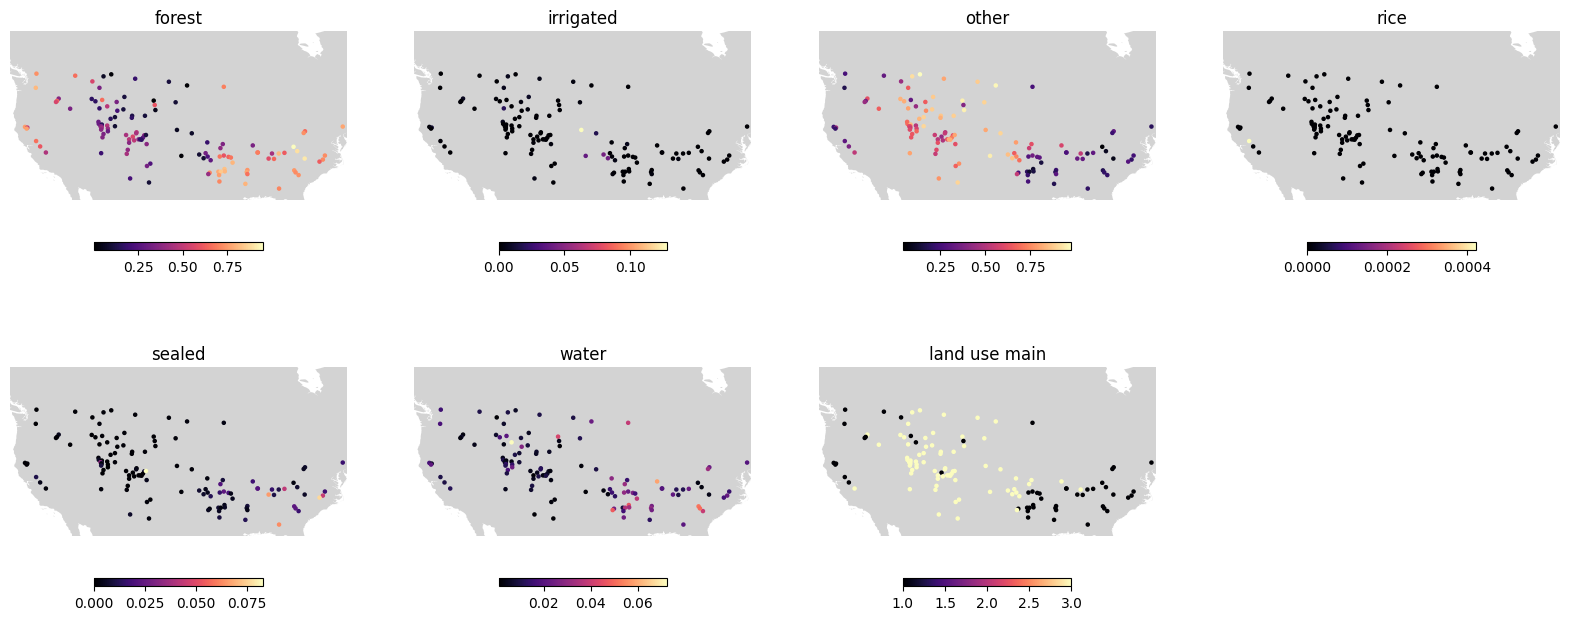

In [101]:
variables = ['fracforest', 'fracirrigated', 'fracother', 'fracrice', 'fracwater', 'fracsealed']
variables.sort()

# load maps
land_use = xr.Dataset({var: xr.open_mfdataset(f'{cfg.PATH_LISFLOOD}/static_maps/{var}_*.nc')['Band1'].compute() for var in variables})
land_use = land_use.rename({var: var[4:] for var in list(land_use)})
land_use = land_use.sel(extent_dct)

# compute statistics
attr_landuse = catchment_statistics(
    land_use, 
    masks, 
    statistic=['mean'], 
    weight=pixarea
).to_pandas()
attr_landuse.sort_index(axis=1, inplace=True)

# compute main land use
lu_classes = {col: i for i, col in enumerate(attr_landuse.columns, start=1)}
attr_landuse['land_use_main'] = attr_landuse.idxmax(axis=1).map(lu_classes)

# rename attributes
attr_landuse.rename(columns={col: col.split('_')[0] if 'mean' in col else col for col in attr_landuse}, inplace=True)
attr_landuse.rename(columns={col: 'frac' + col.split('_')[0] if 'mean' in col else col for col in attr_landuse}, inplace=True)

# plot attributes
plot_attributes(
    attr_landuse, 
    catchments.geometry.x, 
    catchments.geometry.y, 
    ncols=4,
    extent=extent
)

# save
attributes.append(attr_landuse)

### Crop coefficient

processing catchments:   0%|          | 0/123 [00:00<?, ?it/s]

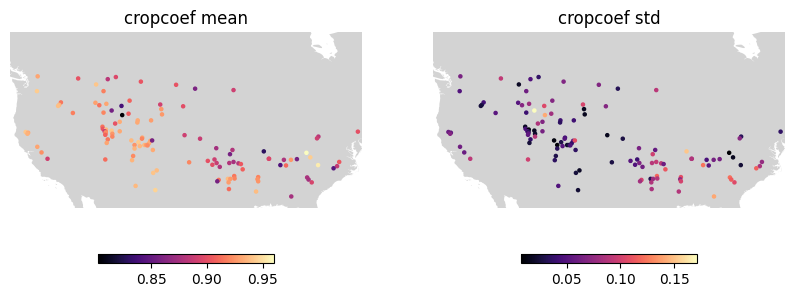

In [102]:
# mapping land use acronym and name
mapping_landuse = {'f': 'forest', 'i': 'irrigated', 'o': 'other'}
variables = ['cropcoef_f', 'cropcoef_i', 'cropcoef_o']

# load maps
crops = xr.Dataset({var: xr.open_mfdataset(f'{cfg.PATH_LISFLOOD}/static_maps/{var}_*.nc')['Band1'].compute() for var in variables})
crops = crops.rename({var: mapping_landuse[var.split('_')[1]] for var in list(crops)})
crops = crops.sel(extent_dct)

# mean weighted by the fraction of pixel covered by each land use
crops = crops.to_array('land_use').weighted(land_use.to_array('land_use').fillna(0)).sum('land_use', skipna=True) 
crops = crops.where(~upArea.isnull())
crops.name = 'cropcoef'

# compute statistics
attr_crops = catchment_statistics(
    crops,
    masks, 
    statistic=['mean', 'std'], 
    weight=pixarea
).to_pandas()

# plot attributes
plot_attributes(
    attr_crops, 
    catchments.geometry.x, 
    catchments.geometry.y, 
    ncols=2,
    extent=extent
)

# save
attributes.append(attr_crops)

### Streams

processing catchments:   0%|          | 0/123 [00:00<?, ?it/s]

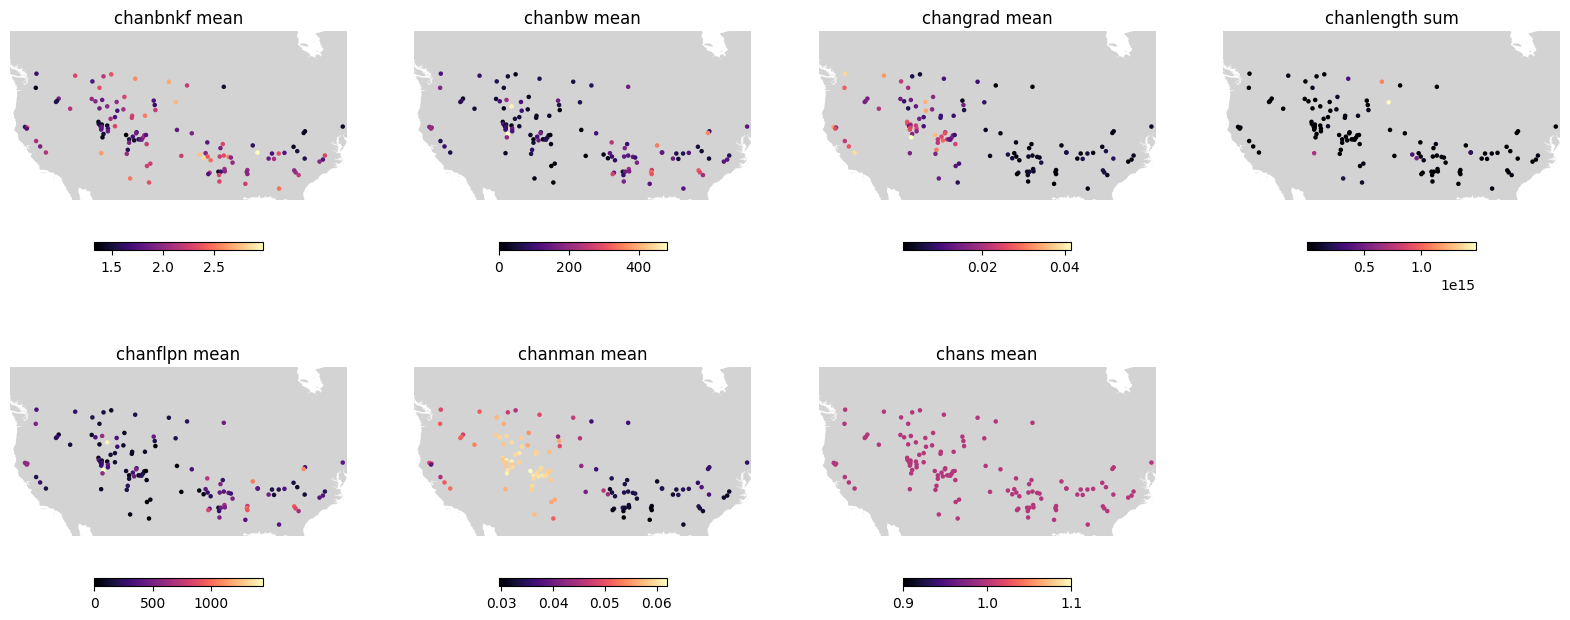

In [103]:
func = {
    'chanbnkf': ['mean'],
    'chanbw': ['mean'],
    'changrad': ['mean'],
    'chanlength': ['sum'],
    'chanflpn': ['mean'],
    'chanman': ['mean'],
    'chans': ['mean'],
}

# load maps
streams = {var: xr.open_mfdataset(f'{cfg.PATH_LISFLOOD}/static_maps/{var}_*.nc')['Band1'].compute() for var in func}
streams = {var: da.rename(var) for var, da in streams.items()}
streams = {var : da.drop_vars([coord for coord in list(da.coords) if coord not in ['lon', 'lat']]) for var, da in streams.items()}
streams = xr.Dataset({var: xr.DataArray(da.data, coords=upArea.coords, name=var) for var, da in streams.items()})
streams = streams.sel(extent_dct)

# mask streams (pixels with depth larger than 1 m)
rivers = streams['chanbnkf'] > 1
# rivers.plot(cmap='Blues')
streams = streams.where(rivers)

# calcular estadístico
statistic = list(np.unique([stat for stats in func.values() for stat in stats]))
attr_streams = catchment_statistics(
    streams, 
    masks, 
    statistic, 
    weight=pixarea
).to_pandas()
cols = [f'{var}_{stat}' for var, stats in func.items() for stat in stats]
attr_streams = attr_streams[cols]

# plot attributes
plot_attributes(
    attr_streams,
    catchments.geometry.x, 
    catchments.geometry.y, 
    ncols=4,
    extent=extent
)

# save
attributes.append(attr_streams)

### Soil properties

loading maps:   0%|          | 0/18 [00:00<?, ?it/s]

processing catchments:   0%|          | 0/123 [00:00<?, ?it/s]

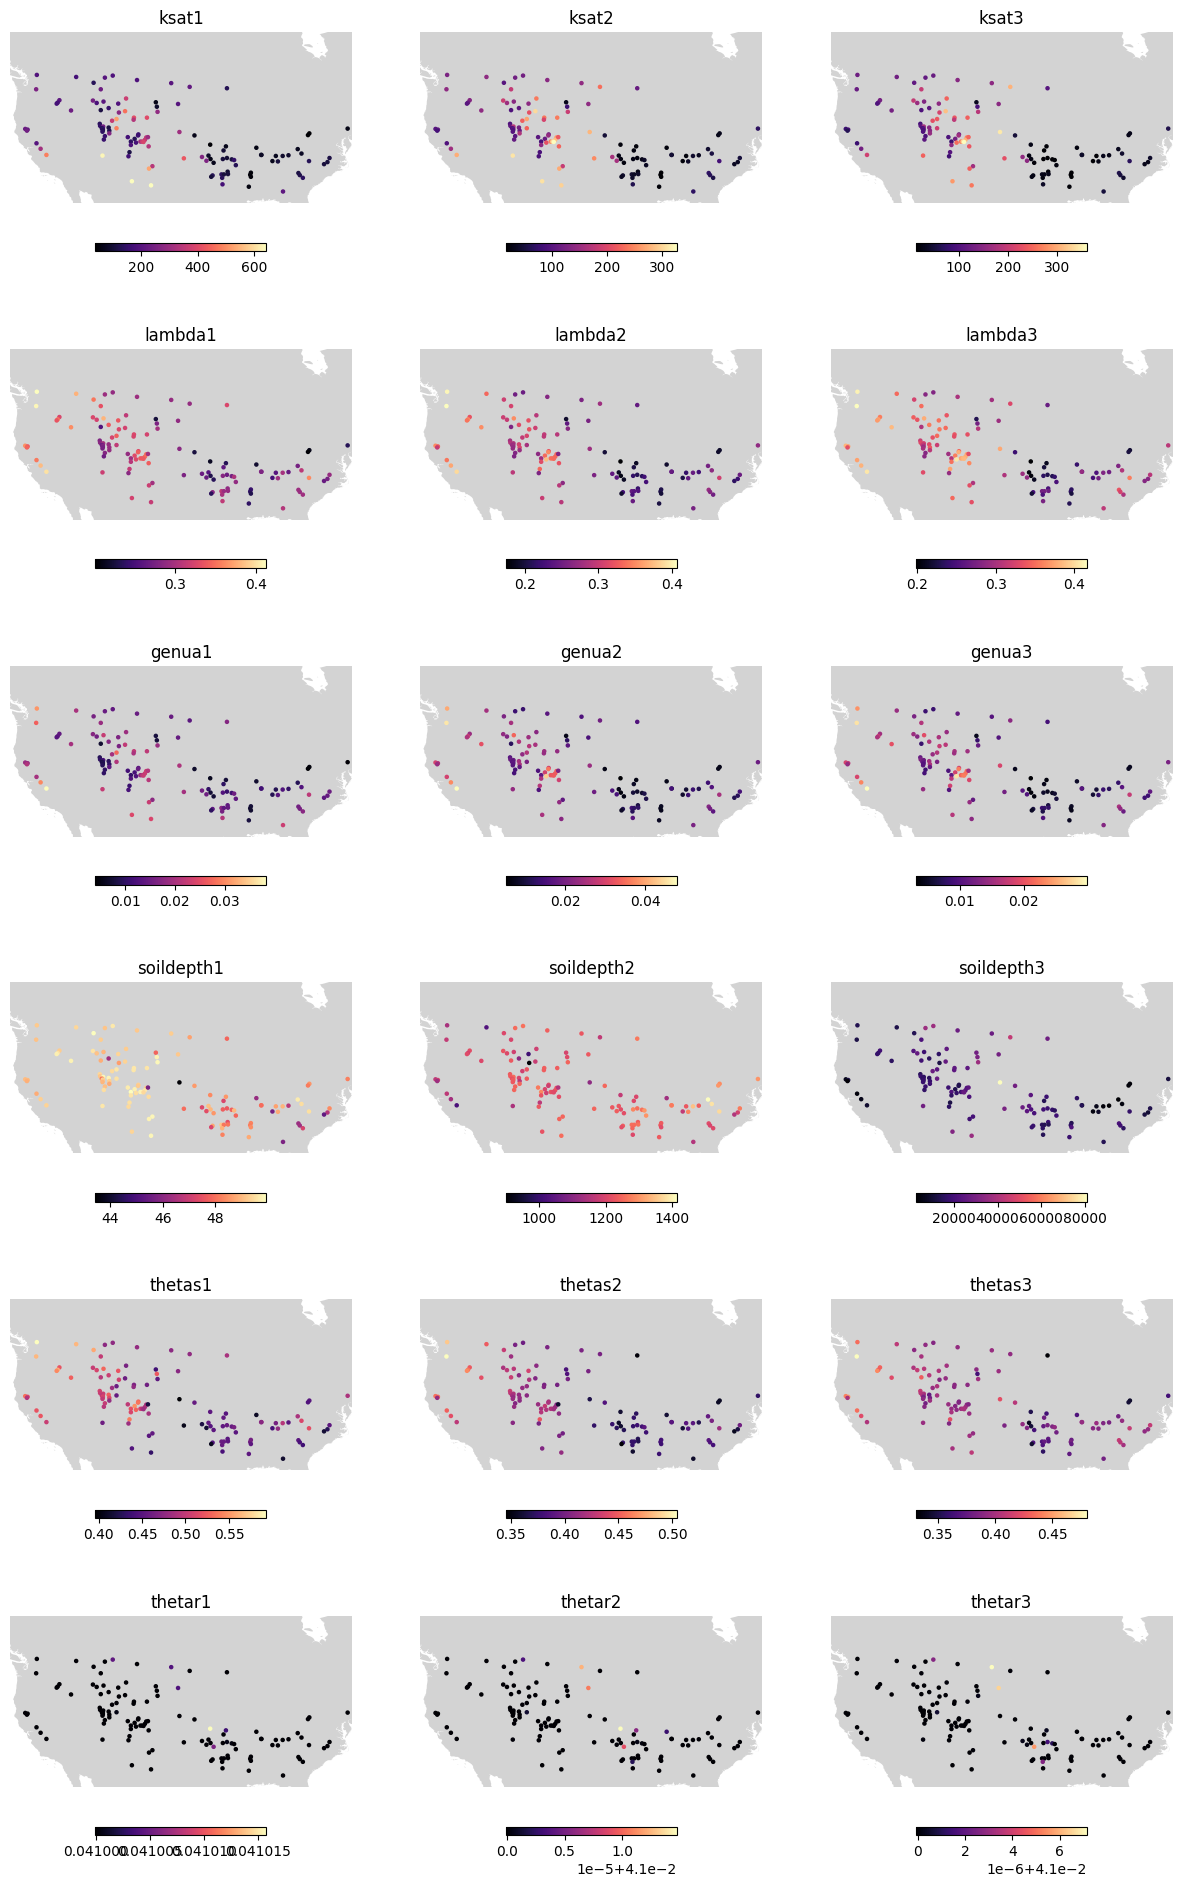

In [104]:
variables = ['ksat', 'lambda', 'genua', 'soildepth', 'thetas', 'thetar']
layers = [1, 2, 3]
maps = [f'{var}{layer}' for var in variables for layer in layers]

# load maps
soils = {}
for var in tqdm(maps, desc='loading maps'):
    files = list((cfg.PATH_LISFLOOD / 'static_maps').glob(f'{var}_*.nc'))
    if len(files) > 1:
        ds = {}
        for file in files:
            # type of land use
            cover = mapping_landuse[file.stem.split('_')[1]]
            # import map
            ds[cover] = xr.open_dataset(file)['Band1']
        ds = xr.Dataset(ds)
        da = ds.to_array('land_use').weighted(land_use.to_array('land_use').fillna(0)).sum('land_use', skipna=True)
        soils[var] = da.where(~upArea.isnull())
    elif len(files) == 1:
        soils[var] = xr.open_dataset(files[0])['Band1']
soils = xr.Dataset(soils)
soils = soils.sortby('lat', ascending=False)
soils = soils.sel(extent_dct)

# compute statistics
attr_soils = catchment_statistics(
    soils, 
    masks, 
    statistic=['mean'], 
    weight=pixarea
).to_pandas()

# rename attributes
attr_soils.rename(columns={col: col.split('_')[0] for col in attr_soils if 'mean' in col}, inplace=True)

# plot attributes
plot_attributes(
    attr_soils, 
    catchments.geometry.x, 
    catchments.geometry.y, 
    ncols=3,
    extent=extent
)

# save
attributes.append(attr_soils)

### LAI

I convert the timeseries of 10-daily timesteps into annual and monthly averages.

processing catchments:   0%|          | 0/123 [00:00<?, ?it/s]

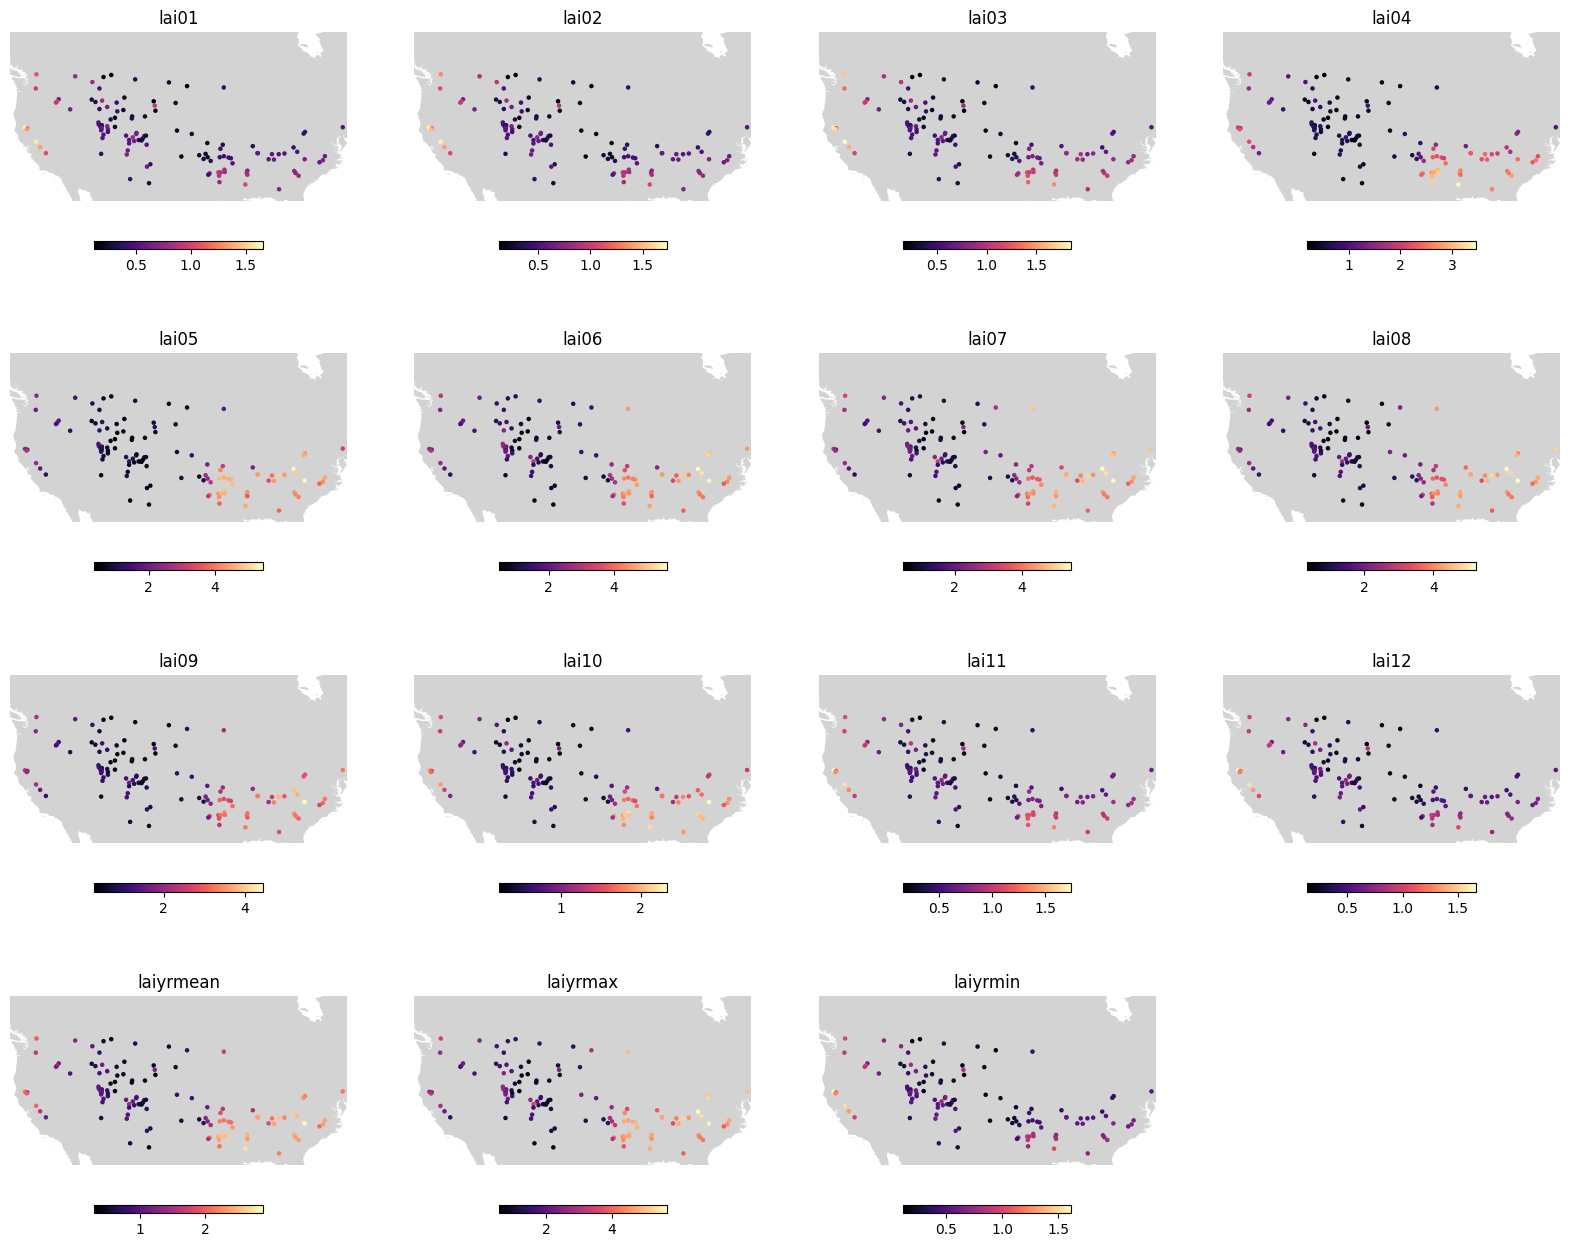

In [105]:
maps = ['laif', 'laii', 'laio']

# load maps
lai = xr.Dataset({var: xr.open_mfdataset(f'{cfg.PATH_LISFLOOD}/static_maps/{var}*.nc')['Band1'] for var in maps})
lai = lai.rename({var: mapping_landuse[var[3]] for var in list(lai)})
lai = lai.sel(extent_dct).compute()

# mean weighted by the portion of pixel covered by each land use
lai = lai.to_array('land_use').weighted(land_use.to_array('land_use').fillna(0)).sum('land_use', skipna=True) 
lai = lai.where(~upArea.isnull())
lai.name = 'lai'
lai['time'] = pd.date_range('2021-01-05', periods=len(lai.time), freq='10D')

# monthly resampling
lai_m = lai.resample(time='MS').mean()
lai_m['time'] = [f'{i:02}' for i in range(1, 13)]
lai_agg = xr.Dataset({f'lai{month}': lai_m.sel(time=month).drop_vars('time') for month in lai_m.time.data})

# annual statistics
lai_agg['laiyrmean'] = lai.mean('time')
lai_agg['laiyrmax'] = lai.max('time')
lai_agg['laiyrmin'] = lai.min('time')

# compute statistics
attr_lai = catchment_statistics(
    lai_agg,
    masks, 
    statistic=['mean'], 
    weight=pixarea.sel(extent_dct)
).to_pandas()

# rename attributes
attr_lai.rename(columns={col: '_'.join(col.split('_')[:-1]) for col in attr_lai if 'mean' in col}, inplace=True)

# plot attributes
plot_attributes(
    attr_lai, 
    catchments.geometry.x, 
    catchments.geometry.y, 
    ncols=4,
    extent=extent
)

# save
attributes.append(attr_lai)

### Water demand

The original demand maps are monthly time series (domestic, energy, industry, livestock) in mm/day for the period 1990-2023. 

I will compute annual and monthly averages and from those I will compute statistics.

In [ ]:
maps = ['dom', 'ene', 'ind', 'liv']

# load maps
# demand = xr.Dataset({var: xr.open_mfdataset(f'{PATH_LISFLOOD}/iberia/maps/{var}_*.nc')[var].compute() for var in maps})

# load maps
demand = {}
start, end = pd.to_datetime(cfg.START), pd.to_datetime('2023-12-31')
dates = pd.date_range(start, end, freq='D')
for use in tqdm(maps):
    
    # load dataset of demand
    da = xr.open_mfdataset(f'{cfg.PATH_LISFLOOD}/static_maps/{use}*.nc')
    da['time'] = da['time'] - pd.Timedelta(days=1)
    da = da.sel(extent_dct).compute()
    
    # compute cachtment statistic
    df = catchment_statistics(
        da, 
        masks, 
        statistic=['mean'], 
        weight=pixarea
    )[f'{use}_mean'].to_pandas()

    # convert dataframe to daily resolution
    daily_df = df.reindex(index=dates).ffill()
    daily_df.index.name = 'time'

    # convert to DataArray
    demand[use] = xr.Dataset.from_dataframe(daily_df).to_array(dim='id', name=use)

# combine all demands in one Dataset
demand = xr.Dataset(demand)

# monthly means
demand_m = demand.groupby('time.month').mean('time')

# annual mean
demand_y = demand.groupby('time.year').mean('time').mean('year')
# demand_y = demand.mean('time')

# combine in a single dataset
demand_agg = xr.Dataset()
for key, da in demand_m.items():
    for month in da.month.data:
        demand_agg[f'{key}_{month:02}'] = da.sel(month=month).drop_vars('month')
    demand_agg[f'{key}_yr'] = demand_y[key]

# convert to volume
# demand_agg = demand_agg * 1e-3 * pixarea

# # compute statistics
# attr_demand = catchment_statistics(demand_agg, masks, statistic=['sum'], weight=pixarea).to_pandas()

# # rename attributes
# attr_demand.rename(columns={col: '_'.join(col.split('_')[:-1]) for col in attr_demand if 'sum' in col}, inplace=True)

attr_demand = demand_agg.to_pandas()

# plot attributes
plot_attributes(
    attr_demand[['dom_yr', 'ene_yr', 'ind_yr', 'liv_yr']],
    catchments.geometry.x,
    catchments.geometry.y,
    ncols=4,
    extent=extent
)

# save
attributes.append(attr_demand)

### Reservoirs

In [107]:
# # load map or reservoir ID
# var = 'reservoirs'
# res_xr = xr.open_mfdataset(f'{cfg.PATH_LISFLOOD}/static_maps/*_{var}_*.nc')['res']
# res_xr = res_xr.sel(extent_dct).compute()

# # extract reservoir ID
# ids = [int(ID) for ID in np.unique(res_xr) if not np.isnan(ID)]
# print('GloFAS represents {0} reservoirs in the study area'.format(len(ids)))

# # load table of total reservoir storage
# storage_pd = pd.read_csv(next((cfg.PATH_LISFLOOD / 'tables').glob('rstor*.txt')), sep='\t', header=None, index_col=0).squeeze().astype('int64')
# storage_pd.index.name = 'ResID'
# storage_pd.name = 'storage'

# # create map of reservoir storage
# storage = res_xr.copy(deep=True)
# for ID in ids:
#     storage = storage.where(res_xr != ID, other=storage_pd.loc[ID])
# # storage /= 1e6
# storage.name = 'storage'
# storage.attrs['units'] = 'm3'
# storage.attrs['standard_name'] = 'capacity'
# storage.attrs['long_name'] = 'reservoir_storage_capacity'

# # compute statistics
# attr_reservoir = catchment_statistics(
#     storage, 
#     masks, 
#     statistic=['count', 'sum']
# ).to_pandas()

# # rename attributes
# attr_reservoir.rename(columns={'storage_count': 'no_reservoirs', 'storage_sum': 'storage_reservoirs'}, inplace=True)

# # plot attributes
# plot_attributes(
#     attr_reservoir, 
#     catchments.geometry.x, 
#     catchments.geometry.y,
#     extent=extent
# )

# # save
# attributes.append(attr_reservoir)

### Lakes

In [108]:
# # load map or reservoir ID
# var = 'lakes'
# lakes_xr = xr.open_mfdataset(f'{cfg.PATH_LISFLOOD}/static_maps/*{var}*.nc')[var]
# lakes_xr = lakes_xr.sel(extent_dct).compute()

# # extract lake ID
# ids = [int(ID) for ID in np.unique(lakes_xr) if not np.isnan(ID)]
# print('GloFAS represents {0} lakes in the study area'.format(len(ids)))

# # load table of lake area
# lakes_pd = pd.read_csv(next((cfg.PATH_LISFLOOD / 'tables').glob('lakearea*.txt')), sep='\t', header=None, index_col=0).squeeze().astype('int64')
# lakes_pd.index.name = 'LakeID'
# lakes_pd.name = 'area'

# # create map of lake area
# lakearea = lakes_xr.copy(deep=True)
# for ID in ids:
#     lakearea = lakearea.where(lakes_xr != ID, other=lakes_pd.loc[ID])
# lakearea.name = 'area'
# lakearea.attrs['units'] = 'm2'
# lakearea.attrs['standard_name'] = 'area'
# lakearea.attrs['long_name'] = 'lake_surface_area'

# # compute statistics
# attr_lake = catchment_statistics(
#     lakearea, 
#     masks, 
#     statistic=['count', 'sum']
# ).to_pandas()

# # rename attributes
# attr_lake.rename(columns={'area_count': 'no_lakes', 'area_sum': 'area_lakes'}, inplace=True)

# # plot attributes
# plot_attributes(
#     attr_lake, 
#     catchments.geometry.x, 
#     catchments.geometry.y,
#     extent=extent
# )

# # save
# attributes.append(attr_lake)

### Export

In [111]:
# concatenate all attributes
attrs = pd.concat(attributes, axis=1)
attrs.index.name = 'GRAND_ID'
attrs.sort_index(axis=0, inplace=True)

print('{0} attributes define the characteristics of {1} catchments'.format(*attrs.shape[::-1]))

# export
attrs.to_csv(cfg.PATH_ATTRS / 'glofas_static_maps.csv')

108 attributes define the characteristics of 123 catchments


## LISFLOOD parameters

In [157]:
# list where parameters wil be appended
parameters = []

In [158]:
# load parameter maps
params = xr.open_mfdataset(f'{cfg.PATH_LISFLOOD}/parameters/*.nc', decode_timedelta=False).drop_vars('wgs_1984')
params = params.sel(extent_dct).compute()
print(f'{len(params)} parameters were calibrated in GloFAS')

14 parameters were calibrated in GloFAS


### Reservoir parameters

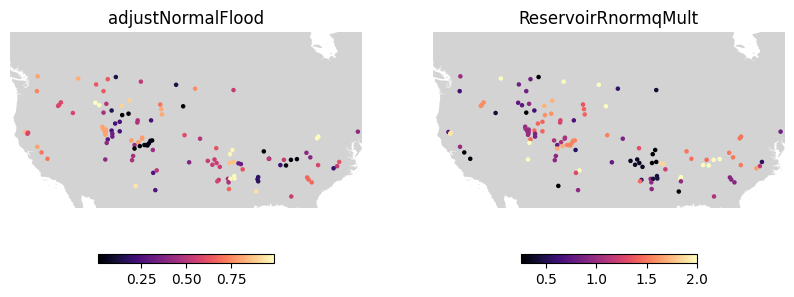

In [159]:
reservoir_parameters = ['adjustNormalFlood', 'ReservoirRnormqMult']

# extract the pixel value of reservoir parameters
catchments_xr = catchments[['LAT', 'LON']].to_xarray()
par_reservoir = params[reservoir_parameters].sel(lat=catchments_xr.LAT, lon=catchments_xr.LON, method='nearest').compute()
par_reservoir = par_reservoir.to_pandas()[reservoir_parameters]

# plot attributes
plot_attributes(
    par_reservoir,
    catchments.geometry.x,
    catchments.geometry.y,
    ncols=4,
    extent=extent
)

# save
parameters.append(par_reservoir)

### Catchment parameters

processing catchments:   0%|          | 0/123 [00:00<?, ?it/s]

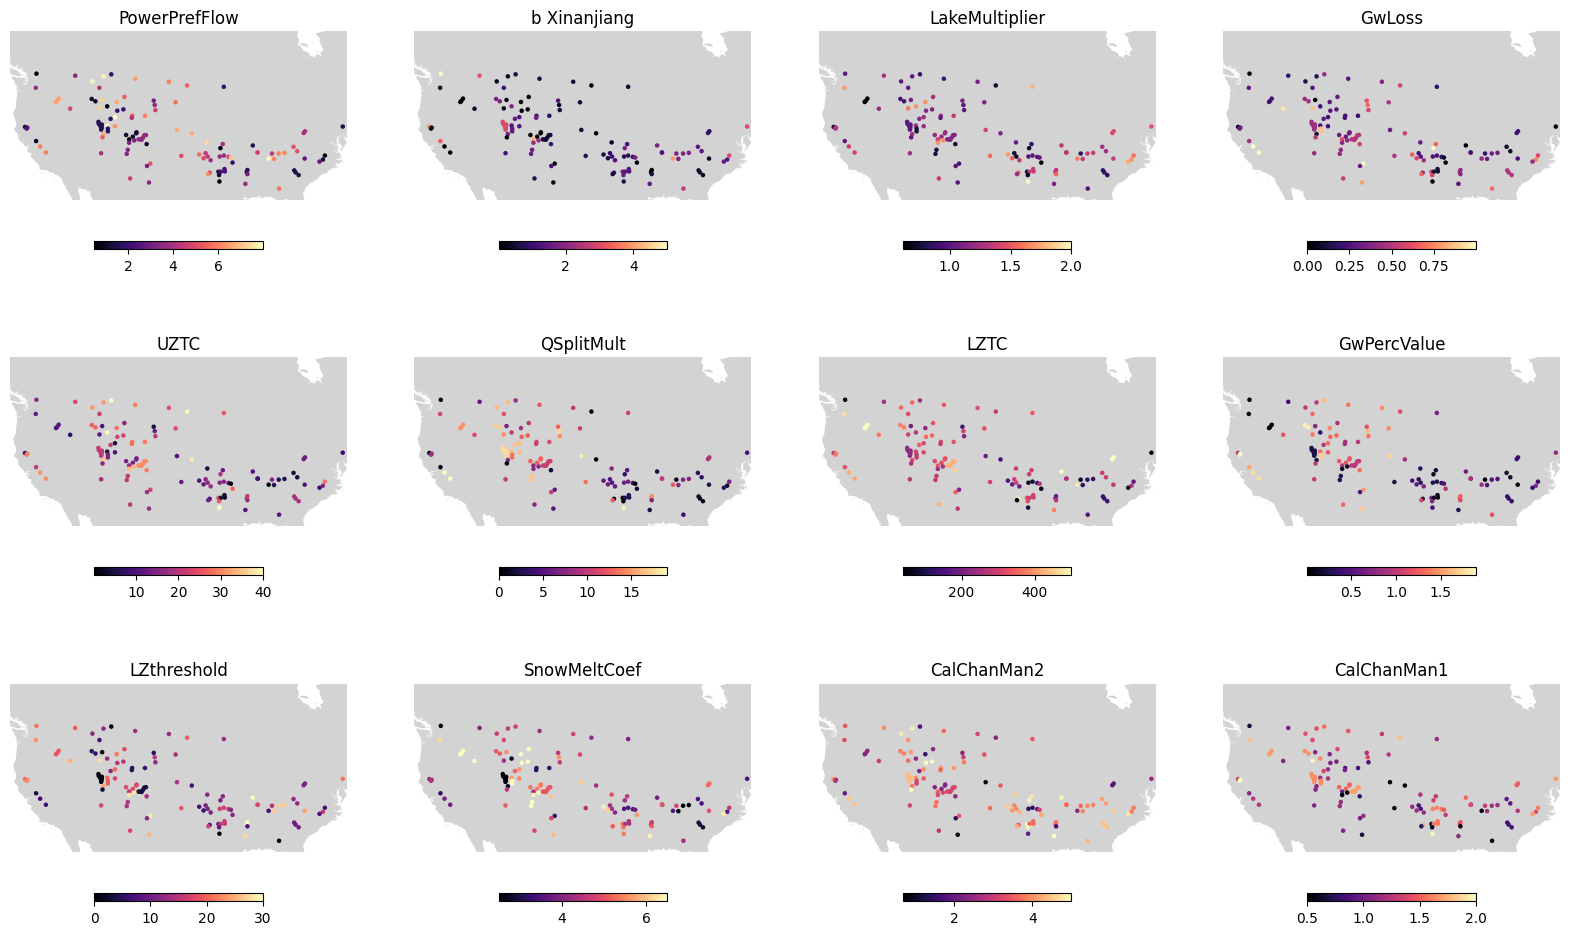

In [160]:
# compute catchment statistics of the other parameters
other_parameters = list(set(list(params)).difference(reservoir_parameters))
par_catchment = catchment_statistics(
    params[other_parameters], 
    masks, 
    statistic=['mean'], 
    weight=pixarea
).to_pandas()
par_catchment.rename(columns={col: '_'.join(col.split('_')[:-1]) for col in par_catchment if 'mean' in col}, inplace=True)

# plot parameters
plot_attributes(
    par_catchment, 
    catchments.geometry.x, 
    catchments.geometry.y, 
    ncols=4,
    extent=extent
)

# save
parameters.append(par_catchment)

### Export

In [163]:
# concatenate
pars = pd.concat(parameters, axis=1)
pars.index.name = 'GRAND_ID'
pars.sort_index(axis=0, inplace=True)

print('{0} attributes define the model parameters of {1} catchments'.format(*pars.shape[::-1]))  

# export
pars.to_csv(cfg.PATH_ATTRS / 'glofas_model_parameters.csv')

14 attributes define the model parameters of 123 catchments
